In [309]:
# veriyi okuma ve önişleme için kullanılacak kütüphaneler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# model değerlendirme ve veriyi ölçeklendirmek için gerekli kütüphaneler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# modeli kurmak için gerekli kütüphaneler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# uyarıları kapatmak için
import warnings
warnings.filterwarnings("ignore")

In [310]:
start_date = "2013-12-01"
end_date = "2023-12-01"
symbol = "GOOGL"
data_stock = yf.download(tickers = symbol, start = start_date, end = end_date)
df = data_stock.copy()
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-12-02,26.614365,26.685434,26.295296,26.388388,26.388388,54873072
2013-12-03,26.300051,26.612614,26.251753,26.357859,26.357859,66976956
2013-12-04,26.310560,26.626125,26.276276,26.480982,26.480982,47616336
2013-12-05,26.456455,26.518019,26.303555,26.459961,26.459961,45302652
2013-12-06,26.771523,26.776777,26.528528,26.773523,26.773523,57094848
...,...,...,...,...,...,...
2023-11-24,138.029999,138.130005,135.990005,136.690002,136.690002,12514300
2023-11-27,136.029999,138.419998,136.000000,136.410004,136.410004,23436500
2023-11-28,136.080002,137.250000,135.419998,137.199997,137.199997,18730000


In [311]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2013-12-02 to 2023-11-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2517 non-null   float64
 1   High       2517 non-null   float64
 2   Low        2517 non-null   float64
 3   Close      2517 non-null   float64
 4   Adj Close  2517 non-null   float64
 5   Volume     2517 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 137.6 KB


In [312]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,2517.0,6.825195e+01,3.631865e+01,2.496200e+01,3.821350e+01,5.665000e+01,9.743000e+01,1.512500e+02
High,2517.0,6.897144e+01,3.676305e+01,2.501400e+01,3.845400e+01,5.729350e+01,9.928000e+01,1.515465e+02
Low,2517.0,6.754240e+01,3.589932e+01,2.454550e+01,3.785250e+01,5.615600e+01,9.640000e+01,1.488990e+02
Close,2517.0,6.827479e+01,3.633478e+01,2.485300e+01,3.812700e+01,5.672100e+01,9.756000e+01,1.498385e+02
Adj Close,2517.0,6.827479e+01,3.633478e+01,2.485300e+01,3.812700e+01,5.672100e+01,9.756000e+01,1.498385e+02
Volume,2517.0,3.804201e+07,2.015947e+07,9.312000e+06,2.610800e+07,3.245800e+07,4.279720e+07,2.571620e+08


In [313]:
#eksik değer?
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [314]:
googl_df = df[["Close"]]

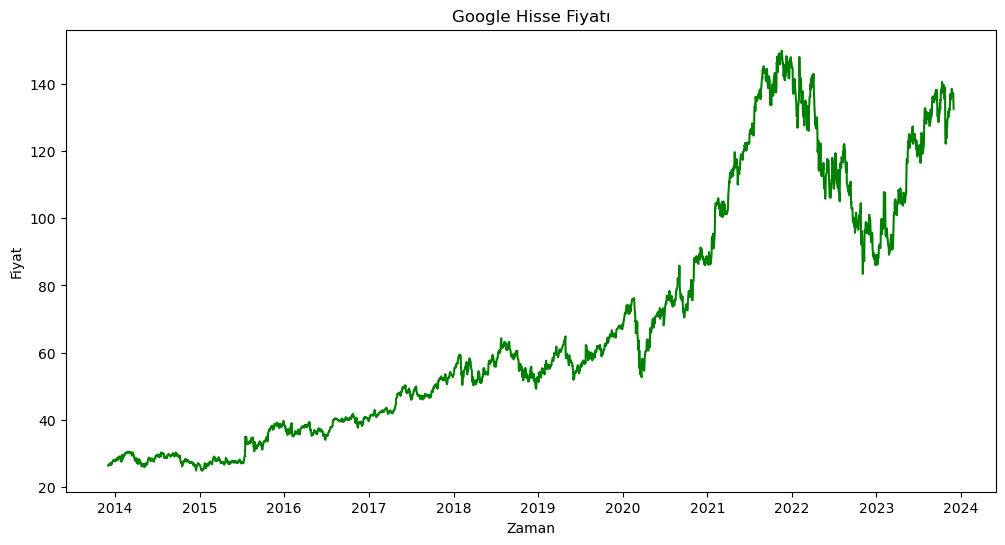

In [315]:
plt.figure(figsize=(12,6))
plt.plot(googl_df.Close, color = "green");
plt.xlabel("Zaman")
plt.ylabel("Fiyat")
plt.title("Google Hisse Fiyatı")
plt.show()

In [316]:
googl_df["Close"].dtype

dtype('float64')

In [317]:
googl_df = googl_df.values

In [318]:
googl_df = googl_df.astype("float32")

In [319]:
googl_df.dtype

dtype('float32')

In [320]:
i = int(round(len(googl_df) * (0.70)))
train = googl_df[:i]
test = googl_df[i:]

In [321]:
i

1762

In [322]:
print("train", train.shape, 
      "test", test.shape)

train (1762, 1) test (755, 1)


In [323]:
scaler = MinMaxScaler(feature_range=(0,1))
train = scaler.fit_transform(train)
test = scaler.fit_transform(test)

In [324]:
df[:1762]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-12-02,26.614365,26.685434,26.295296,26.388388,26.388388,54873072
2013-12-03,26.300051,26.612614,26.251753,26.357859,26.357859,66976956
2013-12-04,26.310560,26.626125,26.276276,26.480982,26.480982,47616336
2013-12-05,26.456455,26.518019,26.303555,26.459961,26.459961,45302652
2013-12-06,26.771523,26.776777,26.528528,26.773523,26.773523,57094848
...,...,...,...,...,...,...
2020-11-23,87.011002,87.299500,85.509003,86.377998,86.377998,22530000
2020-11-24,86.375000,88.323997,86.036499,88.195000,88.195000,27984000
2020-11-25,88.390503,88.518997,87.417999,88.206497,88.206497,19600000


In [325]:
train

array([[0.0238052 ],
       [0.02333185],
       [0.02524081],
       ...,
       [0.98225516],
       [0.99999994],
       [0.97471243]], dtype=float32)

In [326]:
def create_features(veri, timesteps):
    X,Y = [], []
    for i in range(timesteps, len(veri)):
        X.append(veri[i-timesteps:i,0])
        Y.append(veri[i,0])
    
    return np.array(X), np.array(Y)

timesteps = 30

In [327]:
X_train, y_train = create_features(train, timesteps)
X_test, y_test = create_features(test, timesteps)

In [328]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [329]:
#modelleme

In [330]:
model = Sequential()

model.add(LSTM(units=128,
               activation="tanh",
               return_sequences = True,
               input_shape=(1, 30)))
model.add(Dropout(0.2))

model.add(LSTM(units=128,
               activation="tanh",
               return_sequences = True))
model.add(Dropout(0.2))          

model.add(LSTM(units=128, 
               activation="tanh",
               return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(units=1))

In [331]:
model.compile(loss="mean_squared_error", optimizer = "adam")

model.fit(X_train, y_train, epochs = 100, batch_size = 20
         
         
         
         
         
         
         
         
         
         
         
         
         
         
         
         
         
         
         
         
         
        )

Epoch 1/100
87/87 [==============================] - 7s 5ms/step - loss: 0.0224
Epoch 2/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0033
Epoch 3/100
87/87 [==============================] - 1s 6ms/step - loss: 0.0029
Epoch 4/100
87/87 [==============================] - 0s 6ms/step - loss: 0.0024
Epoch 5/100
87/87 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 6/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 7/100
87/87 [==============================] - 0s 6ms/step - loss: 0.0016
Epoch 8/100
87/87 [==============================] - 0s 6ms/step - loss: 0.0016
Epoch 9/100
87/87 [==============================] - 0s 6ms/step - loss: 0.0015
Epoch 10/100
87/87 [==============================] - 0s 5ms/step - loss: 0.0016
Epoch 11/100
87/87 [==============================] - 1s 6ms/step - loss: 0.0015
Epoch 12/100
87/87 [==============================] - 0s 6ms/step - loss: 0.0016
Epoch 13/100
87/87 [=================

In [332]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

23/23 [==============================] - 0s 3ms/step


In [333]:
train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)

In [334]:
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

In [335]:
# train hatası
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
print("rmse train hatası", train_rmse)

# test hatası
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
print("rmse test hatası", test_rmse)

rmse train hatası 1.1338387
rmse test hatası 2.6330023


In [336]:
test_prediction_df = pd.DataFrame(df["Close"][i+timesteps:])

In [337]:
test_prediction_df["predicted"] = test_pred

In [338]:
test_prediction_df.tail(20)

,Close,predicted
Date,,
2023-11-02,127.489998,124.025810
2023-11-03,129.100006,124.916191
2023-11-06,130.250000,126.973915
2023-11-07,130.970001,127.930237
2023-11-08,131.839996,129.251511
2023-11-09,130.240005,130.432602
2023-11-10,132.589996,130.647293
2023-11-13,132.089996,131.801285
2023-11-14,133.619995,131.977341
